In [5]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt

# 1Cycle Policy

In [6]:
from tensorflow.keras.callbacks import Callback



class Linear():
    
    def __init__(self, start, end, stepsize):
        self.start = start
        self.end = end
        self.stepsize = stepsize
        self.n = 0
    
    
    def step(self):
        
        self.n += 1
        alpha = self.n/self.stepsize
        if alpha > 1:
            alpha = 1
        current = self.start + (self.end-self.start)*alpha
        return current
        
    
    
    
class OneCycleScheduler(Callback):
    
    
    def __init__(self, max_lr, min_lr, stepsize, max_mom = 0.95, min_mom = 0.85):
        
        super(OneCycleScheduler, self).__init__()
        
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.current_lr = min_lr
        
        self.max_mom = max_mom
        self.min_mom = min_mom
        self.current_mom = max_mom
        
        self.schedule_lr = [Linear(min_lr, max_lr, stepsize), Linear(max_lr, min_lr/1000, stepsize)]
        
        self.schedule_mom = [Linear(max_mom, min_mom, stepsize), Linear(min_mom, max_mom, stepsize)]
        
        self.stepsize = stepsize
        
        self.phase = 0
        self.step = 0
                             
        self.hist_lr = []
        self.hist_mom = []                    
    
    def on_train_begin(self, logs=None):
        # Lancer les Linear
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_mom(self.mom_schedule().start)
    
    def on_train_batch_begin(self,batch, logs=None):
        #chopper les value lr et mom
        
        self.hist_lr.append(self.get_lr())
        self.hist_mom.append(self.get_mom())
    
    def on_train_batch_end(self, batch, logs=None):
        # avancer d'un pas
        
        self.step += 1
        if self.step > self.stepsize:
            self.phase = 1
        
        self.set_lr(self.schedule_lr[self.phase].step())
        self.set_mom(self.schedule_mom[self.phase].step())
        
    
    
    def get_lr(self):
        try: 
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_mom(self):
        try: 
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass
        
    def set_mom(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass
    
    def lr_schedule(self):
        return self.schedule_lr[self.phase]
    
    def mom_schedule(self):
        return self.schedule_mom[self.phase]
                             
                             
    def plot(self):  
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.hist_lr)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.hist_mom)
        ax.set_title('Momentum')
        
                             
        

# LR Finder

In [188]:
class LRFinder(Callback):
    
    def __init__(self, min_lr: float = 1e-7, max_lr: float = 10,
                 nb_of_steps: int = 1000, beta: float = 0.9):
        
        super(LRFinder,self).__init__()
        self.beta = beta
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.nb_of_steps = nb_of_steps
        
        self.lrs = []
        self.losses = []
        
        self.step = 0
        self.lr = 0
        self.avg_loss = 0
        self.smoothed_loss = 0
        
    def on_train_begin(self, logs = None):
        
        self.lrs =[]
        self.losses = []
        
        self.step = 0
        self.lr = 0
        self.avg_loss = 0
        self.smoothed_loss = 0
        self.min_smoothed_loss = 0
        
    def on_train_batch_begin(self, batch, logs = None):
        
        self.lr = self.next_lr(self.step)
        self.set_lr(self.lr)
    
    def on_train_batch_end(self, batch, logs = None):
        
        logs = logs or {}
        loss = logs.get('loss')
        
        if loss:
            
            self.avg_loss = self.beta*self.avg_loss + (1-self.beta)*loss
            self.smoothed_loss = self.avg_loss/(1-self.beta**(self.step+1))
            
            self.losses.append(self.smoothed_loss)   
            self.lrs.append(self.lr)
            
            if (self.step == 0) or (self.min_smoothed_loss > self.smoothed_loss):
                self.min_smoothed_loss = self.smoothed_loss
            
            if (self.smoothed_loss > 4*self.min_smoothed_loss) or (tf.math.is_nan(self.smoothed_loss)):
                self.model.stop_training = True
        
        if self.step == self.nb_of_steps:
            self.model.stop_training = True
        
        self.step += 1
        
        
    
    def set_lr(self, lr):
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
    
    def next_lr(self, step):
        return self.min_lr * (self.max_lr/self.min_lr)**(step/self.nb_of_steps)
    
    def suggestion(self):
        sls = np.array(self.losses)
        self.opt_idx = np.argmin(sls[1:] - sls[:-1]) + 1 # Step 6
        print('best lr to choose', self.lrs[self.opt_idx])
        return self.lrs[self.opt_idx],self.losses[self.opt_idx]



    
    def plot(self, suggestion = False):
        
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)
        
        if suggestion == True:
            lr_opt,loss_opt = self.suggestion()
            ax.scatter(lr_opt,loss_opt, color = 'red')
        
        
    

# test

In [189]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [190]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

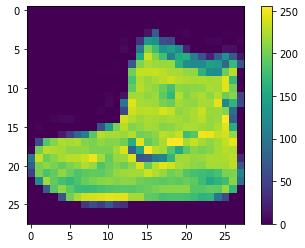

In [191]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

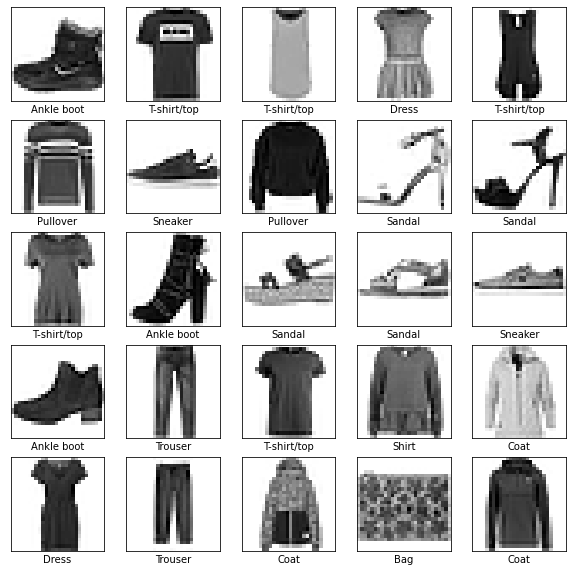

In [192]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]) # empeche les valeurs sur l'axe des x
    plt.yticks([]) # empeche les valeurs sur l'axe des y
    plt.imshow(x_train[i], cmap=plt.cm.binary) #cmap
    plt.grid(False)
    plt.xlabel(class_names[y_train[i]])

plt.show()

In [193]:
x_train , x_test = x_train/255.0, x_test/255.0

In [194]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [195]:
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [196]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [197]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(10000).batch(32)

In [198]:
print(train_ds)
print(test_ds)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>


In [199]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout


model = tf.keras.Sequential([
    Conv2D(6, 3, padding='same', activation='relu'),
    AveragePooling2D(),
    Conv2D(16, 3, padding='valid', activation='relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

In [200]:
lr_finder = LRFinder()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop()#5e-3)

#metric = tf.keras.metrics.Accuracy(name='Accuracy', dtype=None)


In [201]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(train_ds, epochs = 10, callbacks=[lr_finder], verbose = True)

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 2.2958 - accuracy: 0.1573


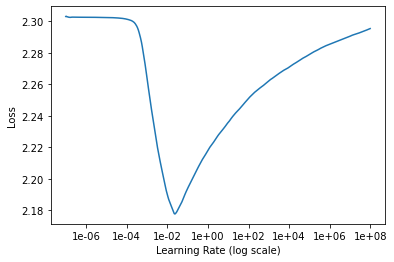

In [202]:
lr_finder.plot()

best lr to choose 0.0009638290236239705


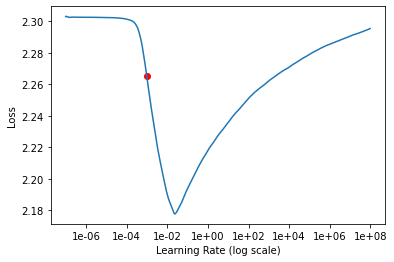

In [203]:
lr_finder.plot(suggestion=True)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.RMSprop(5e-3)

In [367]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [368]:
history = model.fit(train_ds, epochs=5)#, verbose=True)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 13s 7ms/step - loss: 1.7300 - accuracy: 0.7309
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 1.6978 - accuracy: 0.7630
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 1.6997 - accuracy: 0.7612
Epoch 4/5
1875/1875 [==============================] - 12s 7ms/step - loss: 1.6975 - accuracy: 0.7636
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 1.6946 - accuracy: 0.7663


In [369]:
model2 = tf.keras.Sequential([
    Conv2D(6, 3, padding='same', activation='relu'),
    AveragePooling2D(),
    Conv2D(16, 3, padding='valid', activation='relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

In [370]:
model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [371]:
epochs = 5
lr = 5e-3
batch_size = 32
stepsize = np.ceil(len(x_train)/batch_size)*2
#stepsize=stepsize/2

scheduler = OneCycleScheduler(lr, lr/25, stepsize)

In [372]:
history = model2.fit(train_ds, epochs=5, callbacks=[scheduler])#, verbose=True)

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 1.7591 - accuracy: 0.7118
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 1.6669 - accuracy: 0.7941
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 1.6470 - accuracy: 0.8136
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 1.6182 - accuracy: 0.8425
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 1.6050 - accuracy: 0.8560


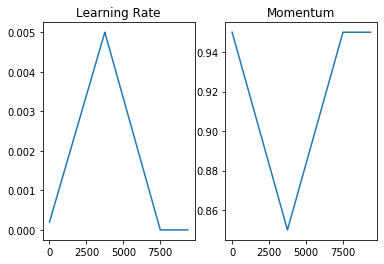

In [373]:
scheduler.plot()